In [1]:
from f1tenth_sim.run_scripts.run_functions import *
import pandas as pd 

from f1tenth_sim.data_tools.plotting_utils import *
from f1tenth_sim.utils.track_utils import CentreLine
import numpy as np
import os
import torch
if os.getcwd().split('/')[-1] == 'Notebooks':
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')


def ensure_path_exists(path):
    if not os.path.exists(path): 
        os.mkdir(path)

save_path = 'Data/LocalMapRacing/'
ensure_path_exists(save_path)


Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim


# High-performance Racing on Unmapped Tracks using Local Maps

This notebook provides the code required to regenerate the results for the article.

1. Local map extraction
    - Generate data: pure pursuit following centre line
    - Profile of local map lengths
    - Statistics tables
2. Racing performance
    - Generate data
        - Local pure pursuit
        - Local MPCC
        - Global pure pursuit
        - Global MPCC
        - End-to-end (TD3 and SAC)
        - Follow-the-gap
    - Plot
        - 
3. Plot compuational performance

## Local map extraction

In [6]:
# test local map extraction
from f1tenth_sim.localmap_racing.LocalMapPP import LocalMapPP
test_id = "c1"
planner = LocalMapPP(test_id, True, False)
test_planning_all_maps(planner, test_id)

Testing on aut...
0 :: 796 LAP COMPLETE: Time: 31.84, Progress: 99.6
Testing on esp...
0 :: 1975 LAP COMPLETE: Time: 79.00, Progress: 99.6
Testing on gbr...
0 :: 1688 LAP COMPLETE: Time: 67.52, Progress: 99.5
Testing on mco...
0 :: 1484 LAP COMPLETE: Time: 59.36, Progress: 99.6


In [13]:

def load_boundary_data(planner_name, test_id, map_name="aut"):
    root = f"Logs/{planner_name}/"
    localmap_data_path = root + f"RawData_{test_id}/LocalMapData_{test_id}/"
    try:
        Logs = np.load(root + f"RawData_{test_id}/SimLog_{map_name}_0.npy")
    except:
        Logs, scans = None, None
    save_path = root + f"LocalMapGeneration_{test_id}/"
    ensure_path_exists(save_path)

    calculated_lengths = []
    projected_lengths = []
    for i in range(len(Logs)):

        boundaries = np.load(localmap_data_path + f"boundaries_{i}.npy")
        boundary_extension= np.load(localmap_data_path + f"boundExtension_{i}.npy") 

        calculated_line = (boundaries[:, :2] + boundaries[:, 2:]) /2
        calculated_el_lengths = np.linalg.norm(np.diff(calculated_line, axis=0), axis=1)
        calculated_lengths.append(np.sum(calculated_el_lengths, axis=0))
        if boundary_extension.shape[0] > 0:
            projected_line = (boundary_extension[:, :2] + boundary_extension[:, 2:]) /2
            projected_el_lengths = np.linalg.norm(np.diff(projected_line, axis=0), axis=1)
            projected_lengths.append(np.sum(projected_el_lengths, axis=0))
        else:
            projected_lengths.append(0)

    return np.array(calculated_lengths), np.array(projected_lengths), Logs[:, -1]


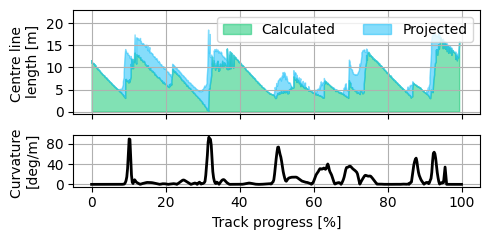

In [14]:
map_name = "aut"

calculated, projected, progresses = load_boundary_data("LocalMapPP", test_id, map_name)
progresses *= 100
centre = CentreLine(map_name)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 2.5), gridspec_kw={'height_ratios': [2, 1]})

ax1.fill_between(progresses, 0, calculated, color=sweedish_green, label="Calculated", alpha=0.5)
ax1.fill_between(progresses, calculated, calculated+projected, color=disco_ball, alpha=0.5, label="Projected")

s_norm = centre.s_path / centre.s_path[-1] * 100
curvature_deg = abs(np.rad2deg(centre.kappa))
ax2.plot(s_norm, curvature_deg, color='black', label="Curvature", linewidth=2)
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))

ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_ylim(-0.5, 23)
ax2.set_xlabel("Track progress [%]")
ax1.set_ylabel("Centre line \nlength [m]")
ax2.set_ylabel("Curvature \n[deg/m]")
ax1.legend(ncol=2)
plt.tight_layout()
ax1.grid()
ax2.grid()
plt.rcParams['pdf.use14corefonts'] = True

plt.savefig(f"{save_path}LengthProgress_{map_name}_{test_id}.svg", bbox_inches='tight', pad_inches=0.01)
plt.savefig(f"{save_path}LengthProgress_{map_name}_{test_id}.pdf", bbox_inches='tight', pad_inches=0.01)

In [84]:
map_list = ["aut", "esp", "gbr"]
root = f"Logs/LocalMapPP/"
test_id = "c1"
localmap_data_path = root + f"RawData_{test_id}/LocalMapData_{test_id}/"

data_dict = []
for map_name in map_list:
    Logs = np.load(root + f"RawData_{test_id}/SimLog_{map_name}_0.npy")
    for i in range(len(Logs)-1):
        local_track = np.load(localmap_data_path + f"local_map_{i}.npy")
        el_lengths = np.linalg.norm(np.diff(local_track[:, :2], axis=0), axis=1)
        data_dict.append({"Map": map_name, "length": np.sum(el_lengths)})

df = pd.DataFrame.from_records(data_dict)

descriptions = df.groupby("Map").describe(percentiles=[])
descriptions = descriptions["length"].reset_index()
descriptions = descriptions.drop(columns=["count", "50%"])

descriptions["Mean $\pm$  Std."] = descriptions["mean"].round(2).astype(str) + " $\pm$ " + descriptions["std"].round(2).astype(str)
descriptions["Min, Max"] = descriptions["min"].round(2).astype(str) + ", " + descriptions["max"].round(2).astype(str)
descriptions = descriptions.drop(columns=["mean", "std", "min", "max"])
descriptions = descriptions.set_index("Map").round(2).T
descriptions.columns = ["AUT", "ESP", "GBR"]

print(descriptions)
descriptions.to_latex(f"{save_path}LengthTable.tex", float_format="%.2f", na_rep="-")

                              AUT               ESP               GBR
Mean $\pm$  Std.  9.37 $\pm$ 3.81  10.68 $\pm$ 4.13  10.38 $\pm$ 4.04
Min, Max               3.7, 19.02        3.7, 24.61        3.7, 24.61


## Generate data for racing performance tests

In [85]:
# Generate local map racing data for two stage planner
test_id = "mu60"
planner = LocalMapPP(test_id, True, True)
test_planning_all_maps(planner, test_id)

plot_trajectory_analysis(planner.name, test_id)

Testing on aut...
0 :: 473 LAP COMPLETE: Time: 18.92, Progress: 99.6
Testing on esp...
0 :: 1006 LAP COMPLETE: Time: 40.24, Progress: 99.7
Testing on gbr...
0 :: 885 LAP COMPLETE: Time: 35.40, Progress: 99.5
Testing on mco...
0 :: 846 LAP COMPLETE: Time: 33.84, Progress: 99.7
Vehicle name: LocalMapPP


In [3]:
# test local MPCC
from f1tenth_sim.localmap_racing.LocalMPCC import LocalMPCC
test_id = "mu60"
planner = LocalMPCC(test_id, True, surpress_output=True)
# test_planning_all_maps(planner, test_id)
test_planning_single_map(planner, "esp", test_id)

plot_trajectory_analysis(planner.name, test_id)

Testing on esp...
Solve failed: ReWarm Start: New outcome: False
S:0.616070 --> Action: [0.4    2.1434]
Solve failed: ReWarm Start: New outcome: False
S:1.003839 --> Action: [0.4    2.1434]
Solve failed: ReWarm Start: New outcome: False
S:4.793611 --> Action: [0.0303 8.    ]
Solve failed: ReWarm Start: New outcome: False
S:4.401849 --> Action: [0.0303 8.    ]
Solve failed: ReWarm Start: New outcome: False
S:3.997859 --> Action: [0.4    2.1434]
0 :: 1029 LAP COMPLETE: Time: 41.16, Progress: 99.6
Vehicle name: LocalMPCC


In [10]:
from f1tenth_sim.classic_racing.GlobalPurePursuit import GlobalPurePursuit

test_id = "mu70"
planner = GlobalPurePursuit(test_id, False, planner_name="FullStackPP")
test_full_stack_all_maps(planner, test_id)

plot_trajectory_analysis(planner.name, test_id)

Testing on aut...
0 :: 503 LAP COMPLETE: Time: 20.12, Progress: 99.6
Testing on esp...
0 :: 1036 LAP COMPLETE: Time: 41.44, Progress: 99.6
Testing on gbr...
0 :: 890 LAP COMPLETE: Time: 35.60, Progress: 99.6
Testing on mco...
0 :: 826 LAP COMPLETE: Time: 33.04, Progress: 99.6
Vehicle name: FullStackPP


In [4]:
from f1tenth_sim.classic_racing.GlobalMPCC3 import GlobalMPCC3

test_id = "mu60"
planner = GlobalMPCC3(test_id, False, planner_name="FullStackMPCC3", surpress_output=True)
test_planning_single_map(planner, "esp", test_id)
# test_full_stack_all_maps(planner, test_id)

plot_trajectory_analysis(planner.name, test_id)

Testing on esp...
0 :: 1152 LAP COMPLETE: Time: 46.08, Progress: 99.6
Vehicle name: FullStackMPCC3


In [2]:
from f1tenth_sim.drl_racing.EndToEndAgent import EndToEndAgent, TrainEndToEndAgent
from f1tenth_sim.data_tools.specific_plotting.plot_drl_training import plot_drl_training

random_seed = 11
train_map = "mco"
torch.use_deterministic_algorithms(True)

np.random.seed(random_seed)
torch.manual_seed(random_seed)
test_id = "TD3"

training_agent = TrainEndToEndAgent(train_map, test_id, {"algorithm": test_id, "training_steps": 30000})
simulate_training_steps(training_agent, train_map, test_id)
plot_drl_training(training_agent.name, test_id)

testing_agent = EndToEndAgent(test_id)
test_mapless_all_maps(testing_agent, test_id)


0 :: 60 COLLISION: Time: 2.40, Progress: 4.9
1 :: 100 COLLISION: Time: 1.60, Progress: 3.1
2 :: 124 COLLISION: Time: 0.96, Progress: 1.5
3 :: 144 COLLISION: Time: 0.80, Progress: 1.5
4 :: 161 COLLISION: Time: 0.68, Progress: 0.8
5 :: 177 COLLISION: Time: 0.64, Progress: 0.7
6 :: 194 COLLISION: Time: 0.68, Progress: 0.6
7 :: 213 COLLISION: Time: 0.76, Progress: 0.6
8 :: 233 COLLISION: Time: 0.80, Progress: 0.7
9 :: 250 COLLISION: Time: 0.68, Progress: 0.7
10 :: 268 COLLISION: Time: 0.72, Progress: 0.8
11 :: 286 COLLISION: Time: 0.72, Progress: 0.7
12 :: 339 COLLISION: Time: 2.12, Progress: 5.4
13 :: 379 COLLISION: Time: 1.60, Progress: 4.2
14 :: 401 COLLISION: Time: 0.88, Progress: 1.4
15 :: 453 COLLISION: Time: 2.08, Progress: 6.2
16 :: 520 COLLISION: Time: 2.68, Progress: 7.7
17 :: 563 COLLISION: Time: 1.72, Progress: 3.8
18 :: 579 COLLISION: Time: 0.64, Progress: 0.7
19 :: 620 COLLISION: Time: 1.64, Progress: 4.3
20 :: 861 COLLISION: Time: 9.64, Progress: 25.0
21 :: 879 COLLISION: Ti

KeyboardInterrupt: 

In [ ]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)
test_id = "SAC"

training_agent = TrainEndToEndAgent(train_map, test_id, {"algorithm": test_id, "training_steps": 60000})
simulate_training_steps(training_agent, train_map, test_id)
plot_drl_training(training_agent.name, test_id)

testing_agent = EndToEndAgent(test_id)
test_mapless_all_maps(testing_agent, test_id)

In [6]:
from f1tenth_sim.mapless_racing.FollowTheGap import FollowTheGap
test_id = "Std"
planner = FollowTheGap(test_id)
test_mapless_all_maps(planner, test_id)
plot_trajectory_analysis(planner.name, test_id)


Testing on aut...
0 :: 173 COLLISION: Time: 6.92, Progress: 33.2
Testing on esp...
0 :: 1144 LAP COMPLETE: Time: 45.76, Progress: 99.6
Testing on gbr...
0 :: 984 LAP COMPLETE: Time: 39.36, Progress: 99.5
Testing on mco...
0 :: 877 LAP COMPLETE: Time: 35.08, Progress: 99.6
Vehicle name: FollowTheGap


## Plot the Racing Performance Results

In [5]:
from f1tenth_sim.data_tools.build_results_df import build_main_df
build_main_df()

summary_df = pd.read_csv("Logs/Summary.csv")


vehicle_id = {
            "EndToEnd_TestSAC": "End-to-end SAC", 
            "EndToEnd_TestTD3": "End-to-end TD3", 
            "FollowTheGap_Std": "Follow the gap", 
            "FullStackMPCC3_mu70": "Global MPCC", 
            "FullStackPP_mu70": "Global two-stage", 
            "LocalMPCC_mu60": "Local MPCC", 
            "LocalMapPP_mu60": "Local two-stage", 
            }
local_df = summary_df.loc[summary_df.VehicleID.isin(vehicle_id)]
print(local_df)

### Quantitative results

VehicleID  End-to-end SAC  End-to-end TD3  Follow the gap  Global MPCC  \
MapName                                                                  
AUT              1.126100        0.993648        0.992506     0.970274   
ESP              1.218860        0.967584        1.055730     0.975272   
GBR              1.173313        0.964935        1.033273     1.020517   

VehicleID  Global two-stage  Local MPCC  Local two-stage  
MapName                                                   
AUT                0.961964    0.976507         0.979001  
ESP                0.898874    0.958048         0.925632  
GBR                0.882719    0.994373         0.930871  


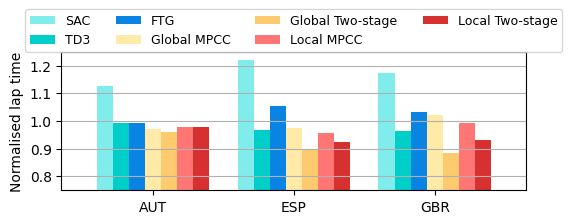

In [7]:

vehicle_id = {
            "EndToEnd_TestSAC": "End-to-end SAC", 
            "EndToEnd_TestTD3": "End-to-end TD3", 
            "FollowTheGap_Std": "Follow the gap", 
            "FullStackMPCC3_mu70": "Global MPCC", 
            "FullStackPP_mu70": "Global two-stage", 
            "LocalMPCC_mu60": "Local MPCC", 
            "LocalMapPP_mu60": "Local two-stage", 
            }

results_df = summary_df.loc[summary_df.VehicleID.isin(vehicle_id)]
results_df = results_df.replace({"VehicleID": vehicle_id})
results_df.insert(3, 'NormTime', results_df['AvgTime'] / results_df.groupby('MapName')['AvgTime'].transform('mean'))
results_df.insert(4, 'NormStd', results_df['StdTime'] / results_df.groupby('MapName')['AvgTime'].transform('mean'))

times_df = results_df.pivot(index="VehicleID", columns="MapName", values="NormTime")
times_df = times_df.drop(columns=["mco"])
times_df.columns = times_df.columns.str.upper()
print(times_df)
times_df = times_df.T

std_df = results_df.pivot(index="VehicleID", columns="MapName", values="NormStd")
std_df = std_df.drop(columns=["mco"])
std_df.columns = std_df.columns.str.upper()
std_df = std_df.T


color_list = ["#81ecec", "#00cec9", "#0984e3", "#ffeaa7", "#fdcb6e", "#ff7675", "#d63031"]

times_df.plot.bar(rot=0, figsize=(6, 1.8), legend=False, color=color_list, width=0.8)


plt.ylabel("Normalised lap time")
plt.xlabel("")
std = 0.25
plt.ylim(1-std, 1+std)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.grid(True, axis="y")

legend_names = ["SAC", "TD3", "FTG", "Global MPCC", "Global Two-stage", "Local MPCC", "Local Two-stage"]
plt.legend(legend_names, ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.35), fontsize=9)
plt.rcParams['pdf.use14corefonts'] = True

plt.savefig(f"{save_path}LaptimesBarPlot.svg", bbox_inches='tight', pad_inches=0)
plt.savefig(f"{save_path}LaptimesBarPlot.pdf", bbox_inches='tight', pad_inches=0)


In [8]:
summary_df = pd.read_csv("Logs/Summary.csv")

vehicle_id = {
            "EndToEnd_TestTD3": "End-to-end TD3", 
            "FollowTheGap_Std": "Follow the gap", 
            "FullStackPP_mu70": "Global two-stage", 
            "LocalMapPP_mu60": "Local two-stage", 
            }


results_df = summary_df.loc[summary_df.VehicleID.isin(vehicle_id)]
results_df = results_df.replace({"VehicleID": vehicle_id})

times_df = results_df.pivot(index="VehicleID", columns="MapName", values="AvgTime")
times_df = times_df.drop(columns=["mco"])
times_df.columns = times_df.columns.str.upper().T
times_df = times_df.round(2)

diffs = []
num_diffs = []
for i in range(len(times_df)):
    dif = {"MapName": f"{times_df.index[i]}"}
    ndif = {"MapName": f"{times_df.index[i]}"}
    for j in range(len(times_df.columns)): 
        if j == len(times_df.columns) - 1:
            dif[times_df.columns[j]] = f"{times_df.iloc[i, j]:.2f} "
            ndif[times_df.columns[j]] = 0
            continue
        num_diff = times_df.iloc[i, j] - times_df.iloc[i, -1]
        percent_diff = num_diff / times_df.iloc[i, -1] * 100
        dif[times_df.columns[j]] = f"{times_df.iloc[i, j]:.2f} ({percent_diff:.1f}\%)"
        ndif[times_df.columns[j]] = percent_diff
    diffs.append(dif)
    num_diffs.append(ndif)

diffs_df = pd.DataFrame(diffs)
diffs_df = diffs_df.set_index("MapName")
diffs_df = diffs_df.round(2)

num_diffs_df = pd.DataFrame(num_diffs)
num_diffs_df = num_diffs_df.set_index("MapName")
num_diffs_df = num_diffs_df.round(2)

means = num_diffs_df.mean(axis=0)
means = means.round(2)

diffs_df = pd.concat([diffs_df, means.to_frame().T])

print(diffs_df)

diffs_df.to_latex(f"{save_path}RelativeLaptimes.tex", float_format="%.2f")


MapName             AUT    ESP    GBR
VehicleID                            
End-to-end TD3    19.13  41.95  36.71
Follow the gap    19.11  45.77  39.31
Global two-stage  18.52  38.97  33.58
Local two-stage   18.85  40.13  35.42
                              AUT             ESP     GBR
End-to-end TD3    19.13 (-47.9\%)  41.95 (14.3\%)  36.71 
Follow the gap    19.11 (-51.4\%)  45.77 (16.4\%)  39.31 
Global two-stage  18.52 (-44.8\%)  38.97 (16.1\%)  33.58 
Local two-stage   18.85 (-46.8\%)  40.13 (13.3\%)  35.42 
0                          -47.73           15.01     0.0


### Trajectories - ESP and GBR

In [13]:

from matplotlib.collections import LineCollection
from f1tenth_sim.data_tools.plotting_utils import *
from f1tenth_sim.utils.MapData import MapData


def make_trajectory_imgs(planner_name, test_id, map_name, test_lap, name="", cbar=False, set_limits=None):
    img_save_path = f"{save_path}Trajectories_{map_name.upper()}/"
    ensure_path_exists(img_save_path)

    map_data = MapData(map_name)
    Logs = np.load(f"Logs/{planner_name}/RawData_{test_id}/SimLog_{map_name}_{test_lap}.npy")

    plt.figure()
    plt.clf()

    map_data.plot_map_img()
    xs, ys = map_data.pts2rc(Logs[:, :2]) # position data
    points = np.concatenate([xs[:, None], ys[:, None]], axis=1).reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = plt.Normalize(2, 8)
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(Logs[:, 3]) # speed data
    lc.set_linewidth(5)
    line = plt.gca().add_collection(lc)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    if set_limits: set_limits(name)
    plt.tight_layout()

    if cbar:
        cbar = plt.colorbar(line, fraction=0.046, pad=0.04, shrink=0.9, ticks=[2, 4, 6, 8])
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(label='Speed [m/s]', size=18)
        name = f"{planner_name}_{test_id}_{map_name.upper()}_{test_lap}_left"

        plt.rcParams['pdf.use14corefonts'] = True
        plt.savefig(img_save_path + name + ".svg", bbox_inches="tight", pad_inches=0)
        plt.savefig(img_save_path + name + ".pdf", bbox_inches="tight", pad_inches=0)
        plt.savefig(img_save_path + name + ".jpg", bbox_inches="tight", pad_inches=0)
    else:
        name = f"{planner_name}_{test_id}_{map_name.upper()}_{test_lap}_left_noC"

        plt.rcParams['pdf.use14corefonts'] = True
        plt.savefig(img_save_path + name + ".svg", bbox_inches="tight", pad_inches=0)
        plt.savefig(img_save_path + name + ".pdf", bbox_inches="tight", pad_inches=0)
        plt.savefig(img_save_path + name + ".jpg", bbox_inches="tight", pad_inches=0)

    plt.close()


In [14]:

map_name = "esp"
lap_n = 0

def set_esp_limits(name):    
    plt.xlim(20, 420)
    plt.ylim(50, 520)
    plt.text(150, 410, name, fontsize=20)

make_trajectory_imgs("LocalMPCC", "mu60", map_name, lap_n, "Local MPCC", True, set_esp_limits)
make_trajectory_imgs("FollowTheGap", "Std", map_name, lap_n, "Follow the gap", False, set_esp_limits)
make_trajectory_imgs("EndToEnd", "TestTD3", map_name, lap_n, "End-to-end TD3", False, set_esp_limits)


 FTG | EndToEnd | LocalMPCC
:---: | :---: | :---:
![](../Data/LocalMapRacing/Trajectories_ESP/FollowTheGap_Std_ESP_0_left_noC.svg) | ![](../Data/LocalMapRacing/Trajectories_ESP/EndToEnd_TestTD3_ESP_0_left_noC.svg) | ![](../Data/LocalMapRacing/Trajectories_ESP/LocalMPCC_mu60_ESP_0_left.svg)

In [15]:

def set_gbr_limits(name):    
    plt.xlim(800, 1310)
    plt.ylim(430, 870)
    plt.text(1000, 510, name, fontsize=20)

map_name = "gbr"
lap_n = 3

make_trajectory_imgs("LocalMapPP", "mu60", map_name, lap_n, "Local two-stage", True, set_gbr_limits)
make_trajectory_imgs("FullStackPP", "mu60", map_name, lap_n, "Global two-stage", False, set_gbr_limits)


 FullStackPP | LocalMapPP 
:---: | :---: 
![](../Data/LocalMapRacing/Trajectories_GBR/FullStackPP_mu60_GBR_3_left_noC.svg) |  ![](../Data/LocalMapRacing/Trajectories_GBR/LocalMapPP_mu60_GBR_3_left.svg)

### Speed Profile - AUT

/tmp/ipykernel_78234/1819063469.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(np.arange(-20, 101, 20), fontsize=9)


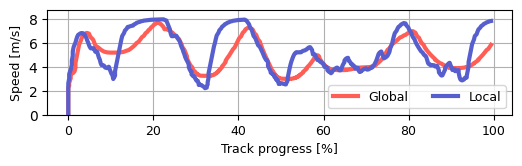

In [19]:
map_name = "aut"
test_lap = 0

Logs1 = np.load(f"Logs/FullStackPP/RawData_mu70/SimLog_{map_name}_{test_lap}.npy")
Logs2 = np.load(f"Logs/LocalMapPP/RawData_mu60/SimLog_{map_name}_{test_lap}.npy")


plt.figure(figsize=(6, 3))
ax1 = plt.subplot(2, 1, 1)

ax1.plot(Logs1[:, 9]*100, Logs1[:, 3], color=sunset_orange, linewidth=3, label="Global")
ax1.plot(Logs2[:, 9]*100, Logs2[:, 3], color=periwinkle, linewidth=3, label="Local")

ax1.grid(True)
ax1.legend(ncol=2, fontsize=9)
ax1.set_xlabel("Track progress [%]", fontsize=9)
ax1.set_ylabel("Speed [m/s]", fontsize=9)
ax1.set_xticklabels(np.arange(-20, 101, 20), fontsize=9)
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_ylim(0, 8.8)

name = f"SpeedComparison_{test_id}_{map_name.upper()}_{test_lap}"
plt.rcParams['pdf.use14corefonts'] = True

plt.savefig(save_path + name + ".svg", bbox_inches="tight", pad_inches=0)
plt.savefig(save_path + name + ".pdf", bbox_inches="tight", pad_inches=0)

### Local Map Examples

In [29]:
import numpy as np 
import matplotlib.pyplot as plt
import os
from f1tenth_sim.data_tools.plotting_utils import *
from matplotlib.collections import LineCollection
import trajectory_planning_helpers as tph
from f1tenth_sim.utils.MapData import MapData

def ensure_path_exists(path):
    if not os.path.exists(path): 
        os.mkdir(path)


def reoreintate_pts(pts, position, theta):
    rotation_mtx = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    pts = np.matmul(pts, rotation_mtx.T) + position

    return pts

def render_local_maps(planner_name, test_id, map_name="aut", i=0, cbar=False):
    root = f"Logs/{planner_name}/"
    raceline_data_path = root + f"RawData_{test_id}/RacingLineData_{test_id}/"
    localmap_data_path = root + f"RawData_{test_id}/LocalMapData_{test_id}/"
    Logs = np.load(root + f"RawData_{test_id}/SimLog_{map_name}_0.npy")
    ensure_path_exists(root + f"Images_{test_id}/")
    data_img_path = f"Data/LocalMapRacing/LocalRacelines/" 
    raceline_img_path = root + f"Images_{test_id}/" + f"LocalRaceline_{test_id}/"
    ensure_path_exists(raceline_img_path)

    map_data = MapData(map_name)
    
    local_track = np.load(localmap_data_path + f"local_map_{i}.npy")
    raceline = np.load(raceline_data_path + f"LocalRaceline_{i+1}.npy")

    plt.figure(1)
    plt.clf()
    map_data.plot_map_img_light()

    position = Logs[i+1, :2]
    orientation = Logs[i+1, 4]


    pts = reoreintate_pts(local_track[:, :2], position, orientation)
    xs, ys = map_data.pts2rc(pts)
    plt.plot(xs, ys, '--', linewidth=2, color='black')

    vs = raceline[:, 2]
    pts = reoreintate_pts(raceline[:, :2], position, orientation)
    xs, ys = map_data.pts2rc(pts)
    points = np.concatenate([xs[:, None], ys[:, None]], axis=1)
    points = points.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = plt.Normalize(2, 8)
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(vs)
    lc.set_linewidth(5)
    line = plt.gca().add_collection(lc)

    x1s, y1s = map_data.pts2rc(position[None, :])
    l = 12
    plt.arrow(x1s[0], y1s[0], np.cos(orientation)*l, np.sin(orientation)*l, color="#8854d0", zorder=10, width=3, head_width=6, head_length=5)


    b = 20
    x_min = np.min(xs) - b
    x_max = np.max(xs) + b
    y_min = np.min(ys) - b
    y_max = np.max(ys) + b
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.tight_layout()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.rcParams['pdf.use14corefonts'] = True

    if cbar:
        cbar = plt.colorbar(line, shrink=0.43)
        plt.gca().set_aspect('equal', adjustable='box')
        cbar.ax.tick_params(labelsize=22)
        cbar.set_label(label='Speed [m/s]', size=20)
        plt.rcParams['pdf.use14corefonts'] = True
        plt.savefig(raceline_img_path + f"Raceline_{i}_c.svg")
        plt.savefig(data_img_path + f"Raceline_{i}_c.pdf", bbox_inches="tight", pad_inches=0.05)
        plt.savefig(data_img_path + f"Raceline_{i}_c.svg", bbox_inches="tight", pad_inches=0.05)
    else:
        plt.savefig(raceline_img_path + f"Raceline_{i}.svg")
        plt.savefig(data_img_path + f"Raceline_{i}.pdf", bbox_inches="tight", pad_inches=0.05)
        plt.savefig(data_img_path + f"Raceline_{i}.svg", bbox_inches="tight", pad_inches=0.05)

    plt.close()

render_local_maps("LocalMapPP", "mu60", "aut", 11, False)
render_local_maps("LocalMapPP", "mu60", "aut", 326, True)



 LocalMapPP (11) | LocalMapPP (326)
:---: | :---: 
![](../Data/LocalMapRacing/LocalRacelines/Raceline_11.svg) |  ![](../Data/LocalMapRacing/LocalRacelines/Raceline_326_c.svg)

### Computational requirements

                    PerceptionTime  PlanningTime
Follow \nthe gap          0.000000      0.000207
End-to-end \nTD3          0.000000      0.001818
Global \ntwo-stage        0.001120      0.000214
Global \nMPCC             0.001179      0.044547
Local \ntwo-stage         0.011789      0.007449
Local \nMPCC              0.007668      0.132931


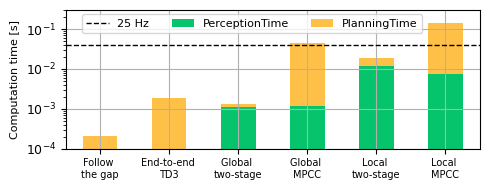

In [31]:
map_name = "esp"

vehicle_id = {
            "FollowTheGap_Std": "Follow \nthe gap", 
            "EndToEnd_TestTD3": "End-to-end \nTD3", 
            "FullStackPP_mu60": "Global \ntwo-stage", 
            "FullStackMPCC_mu60": "Global \nMPCC", 
            "LocalMapPP_mu60": "Local \ntwo-stage", 
            "LocalMPCC_mu60": "Local \nMPCC"}

perception_id = {
            "FollowTheGap_Std": None, 
            "EndToEnd_TestTD3": None, 
            "FullStackPP_mu60": "localise", 
            "FullStackMPCC_mu60": "localise", 
            "LocalMapPP_mu60": "generate_line_local_map", 
            "LocalMPCC_mu60": "generate_line_local_map"}

planning_times = {}
perception_times = {}

for k in vehicle_id.keys():
    planner_name = k.split('_')[0]
    test_id = k.split('_')[1]
    path = f"Logs/{planner_name}/RawData_{test_id}/"

    df = pd.read_csv(path + f"Profile_{map_name}_{test_id}.csv")
    df["cumtime"] = df["cumtime"].astype(float, errors="ignore")  # Convert cumtime column to float
    df["ncalls"] = pd.to_numeric(df["ncalls"], errors='coerce')  # Convert cumtime column to float

    planning = df.loc[df["func"] == "plan"]
    if k[0] == "L":
        ct = df.loc[df["func"] == "generate_line_local_map"].cumtime.values[0]
        planning_time = (planning.cumtime.values[0] -  ct) / planning.ncalls.values[0]
    else:
        planning_time = planning.cumtime.values[0] / planning.ncalls.values[0]
    planning_times[vehicle_id[k]] = planning_time

    if perception_id[k] is not None:
        perception = df.loc[df["func"] == perception_id[k]]
        perception_time = perception["cumtime"].values[0] / perception["ncalls"].values[0]
        perception_times[vehicle_id[k]] = perception_time
    else:
        perception_times[vehicle_id[k]] = 0

planning_times = pd.DataFrame.from_dict(planning_times, orient="index", columns=["PlanningTime"])
perception_times = pd.DataFrame.from_dict(perception_times, orient="index", columns=["PerceptionTime"])
computation_table = pd.concat([perception_times, planning_times], axis=1)
print(computation_table)

computation_table.plot(kind='bar', use_index=True, stacked=True, logy=True, color=[sweedish_green, nartjie], figsize=(5, 2.), rot=0)
plt.ylim([0.0001, 0.3])
plt.plot(plt.xlim(), [0.04, 0.04], 'k--', linewidth=1, label="25 Hz")
plt.legend(ncol=3, loc="center", bbox_to_anchor=(0.45, 0.9), fontsize=8)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize=7)
plt.yticks(fontsize=9)
plt.ylabel("Computation time [s]", fontsize=8)

plt.tight_layout()
plt.grid()
plt.rcParams['pdf.use14corefonts'] = True

plt.savefig(f"Data/LocalMapRacing/computation_times.svg", bbox_inches='tight', pad_inches=0)
plt.savefig(f"Data/LocalMapRacing/computation_times.pdf", bbox_inches='tight', pad_inches=0)
plt.savefig(f"Data/LocalMapRacing/computation_times.jpeg", bbox_inches='tight', pad_inches=0, dpi=300)
